In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
import lmfit
from pytz import timezone
import vaex
import pvlib

import sys
sys.path.append('../../../')

from utils.plot import config_matplotlib, figsize, fig_save_and_show  # noqa: E402

config_matplotlib()
latex_img_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/'


'original columns:'

Index(['Battery Pack Voltage', 'Pilot Duty Cycle', 'Pilot Motor On',
       'Pilot Boat On', 'ESC Duty Cycle', 'Motor Angular Speed',
       'MPPT 1 Input Voltage', 'MPPT 2 Input Voltage', 'MPPT 3 Input Voltage',
       'MPPT 4 Input Voltage', 'MPPT 1 Output Voltage',
       'MPPT 2 Output Voltage', 'MPPT 3 Output Voltage',
       'MPPT 4 Output Voltage', 'MPPT 1 Input Current', 'MPPT 2 Input Current',
       'MPPT 3 Input Current', 'MPPT 4 Input Current', 'MPPT 1 Duty Cycle',
       'MPPT 2 Duty Cycle', 'MPPT 3 Duty Cycle', 'MPPT 4 Duty Cycle',
       'MPPT 1 Input Power', 'MPPT 2 Input Power', 'MPPT 3 Input Power',
       'MPPT 4 Input Power', 'MPPTs Input Power', 'MPPT 1 Output Current',
       'MPPT 2 Output Current', 'MPPT 3 Output Current',
       'MPPT 4 Output Current', 'MPPTs Output Current', 'MPPT 1 Output Power',
       'MPPT 2 Output Power', 'MPPT 3 Output Power', 'MPPT 4 Output Power',
       'MPPTs Output Power', 'Battery Current', 'Battery Power',
       'ESC Input Curre

'renamed columns:'

{'Battery Pack Voltage': 'batt_v',
 'Battery Current': 'batt_i',
 'ESC Duty Cycle': 'esc_D',
 'Motor Angular Speed': 'motor_w',
 'ESC Input Power': 'esc_p_in',
 'ESC Input Current': 'esc_i_in',
 'MPPT 1 Input Current': 'mppt1_ii',
 'MPPT 2 Input Current': 'mppt2_ii',
 'MPPT 3 Input Current': 'mppt3_ii',
 'MPPT 4 Input Current': 'mppt4_ii',
 'MPPT 1 Input Voltage': 'mppt1_vi',
 'MPPT 2 Input Voltage': 'mppt2_vi',
 'MPPT 3 Input Voltage': 'mppt3_vi',
 'MPPT 4 Input Voltage': 'mppt4_vi',
 'MPPT 1 Duty Cycle': 'mppt1_d',
 'MPPT 2 Duty Cycle': 'mppt2_d',
 'MPPT 3 Duty Cycle': 'mppt3_d',
 'MPPT 4 Duty Cycle': 'mppt4_d',
 'MPPT 1 Output Current': 'mppt1_io',
 'MPPT 2 Output Current': 'mppt2_io',
 'MPPT 3 Output Current': 'mppt3_io',
 'MPPT 4 Output Current': 'mppt4_io',
 'Solar POA': 'solar_poa',
 'Wind Speed': 'wind_v',
 'Air Temperature': 'air_t'}

'selected columns:'

Index(['batt_v', 'batt_i', 'esc_D', 'motor_w', 'esc_p_in', 'esc_i_in', 'mppt1_ii',
       'mppt2_ii', 'mppt3_ii', 'mppt4_ii', 'mppt1_vi', 'mppt2_vi', 'mppt3_vi',
       'mppt4_vi', 'mppt1_d', 'mppt2_d', 'mppt3_d', 'mppt4_d', 'mppt1_io',
       'mppt2_io', 'mppt3_io', 'mppt4_io', 'solar_poa', 'wind_v', 'air_t'],
      dtype='object')

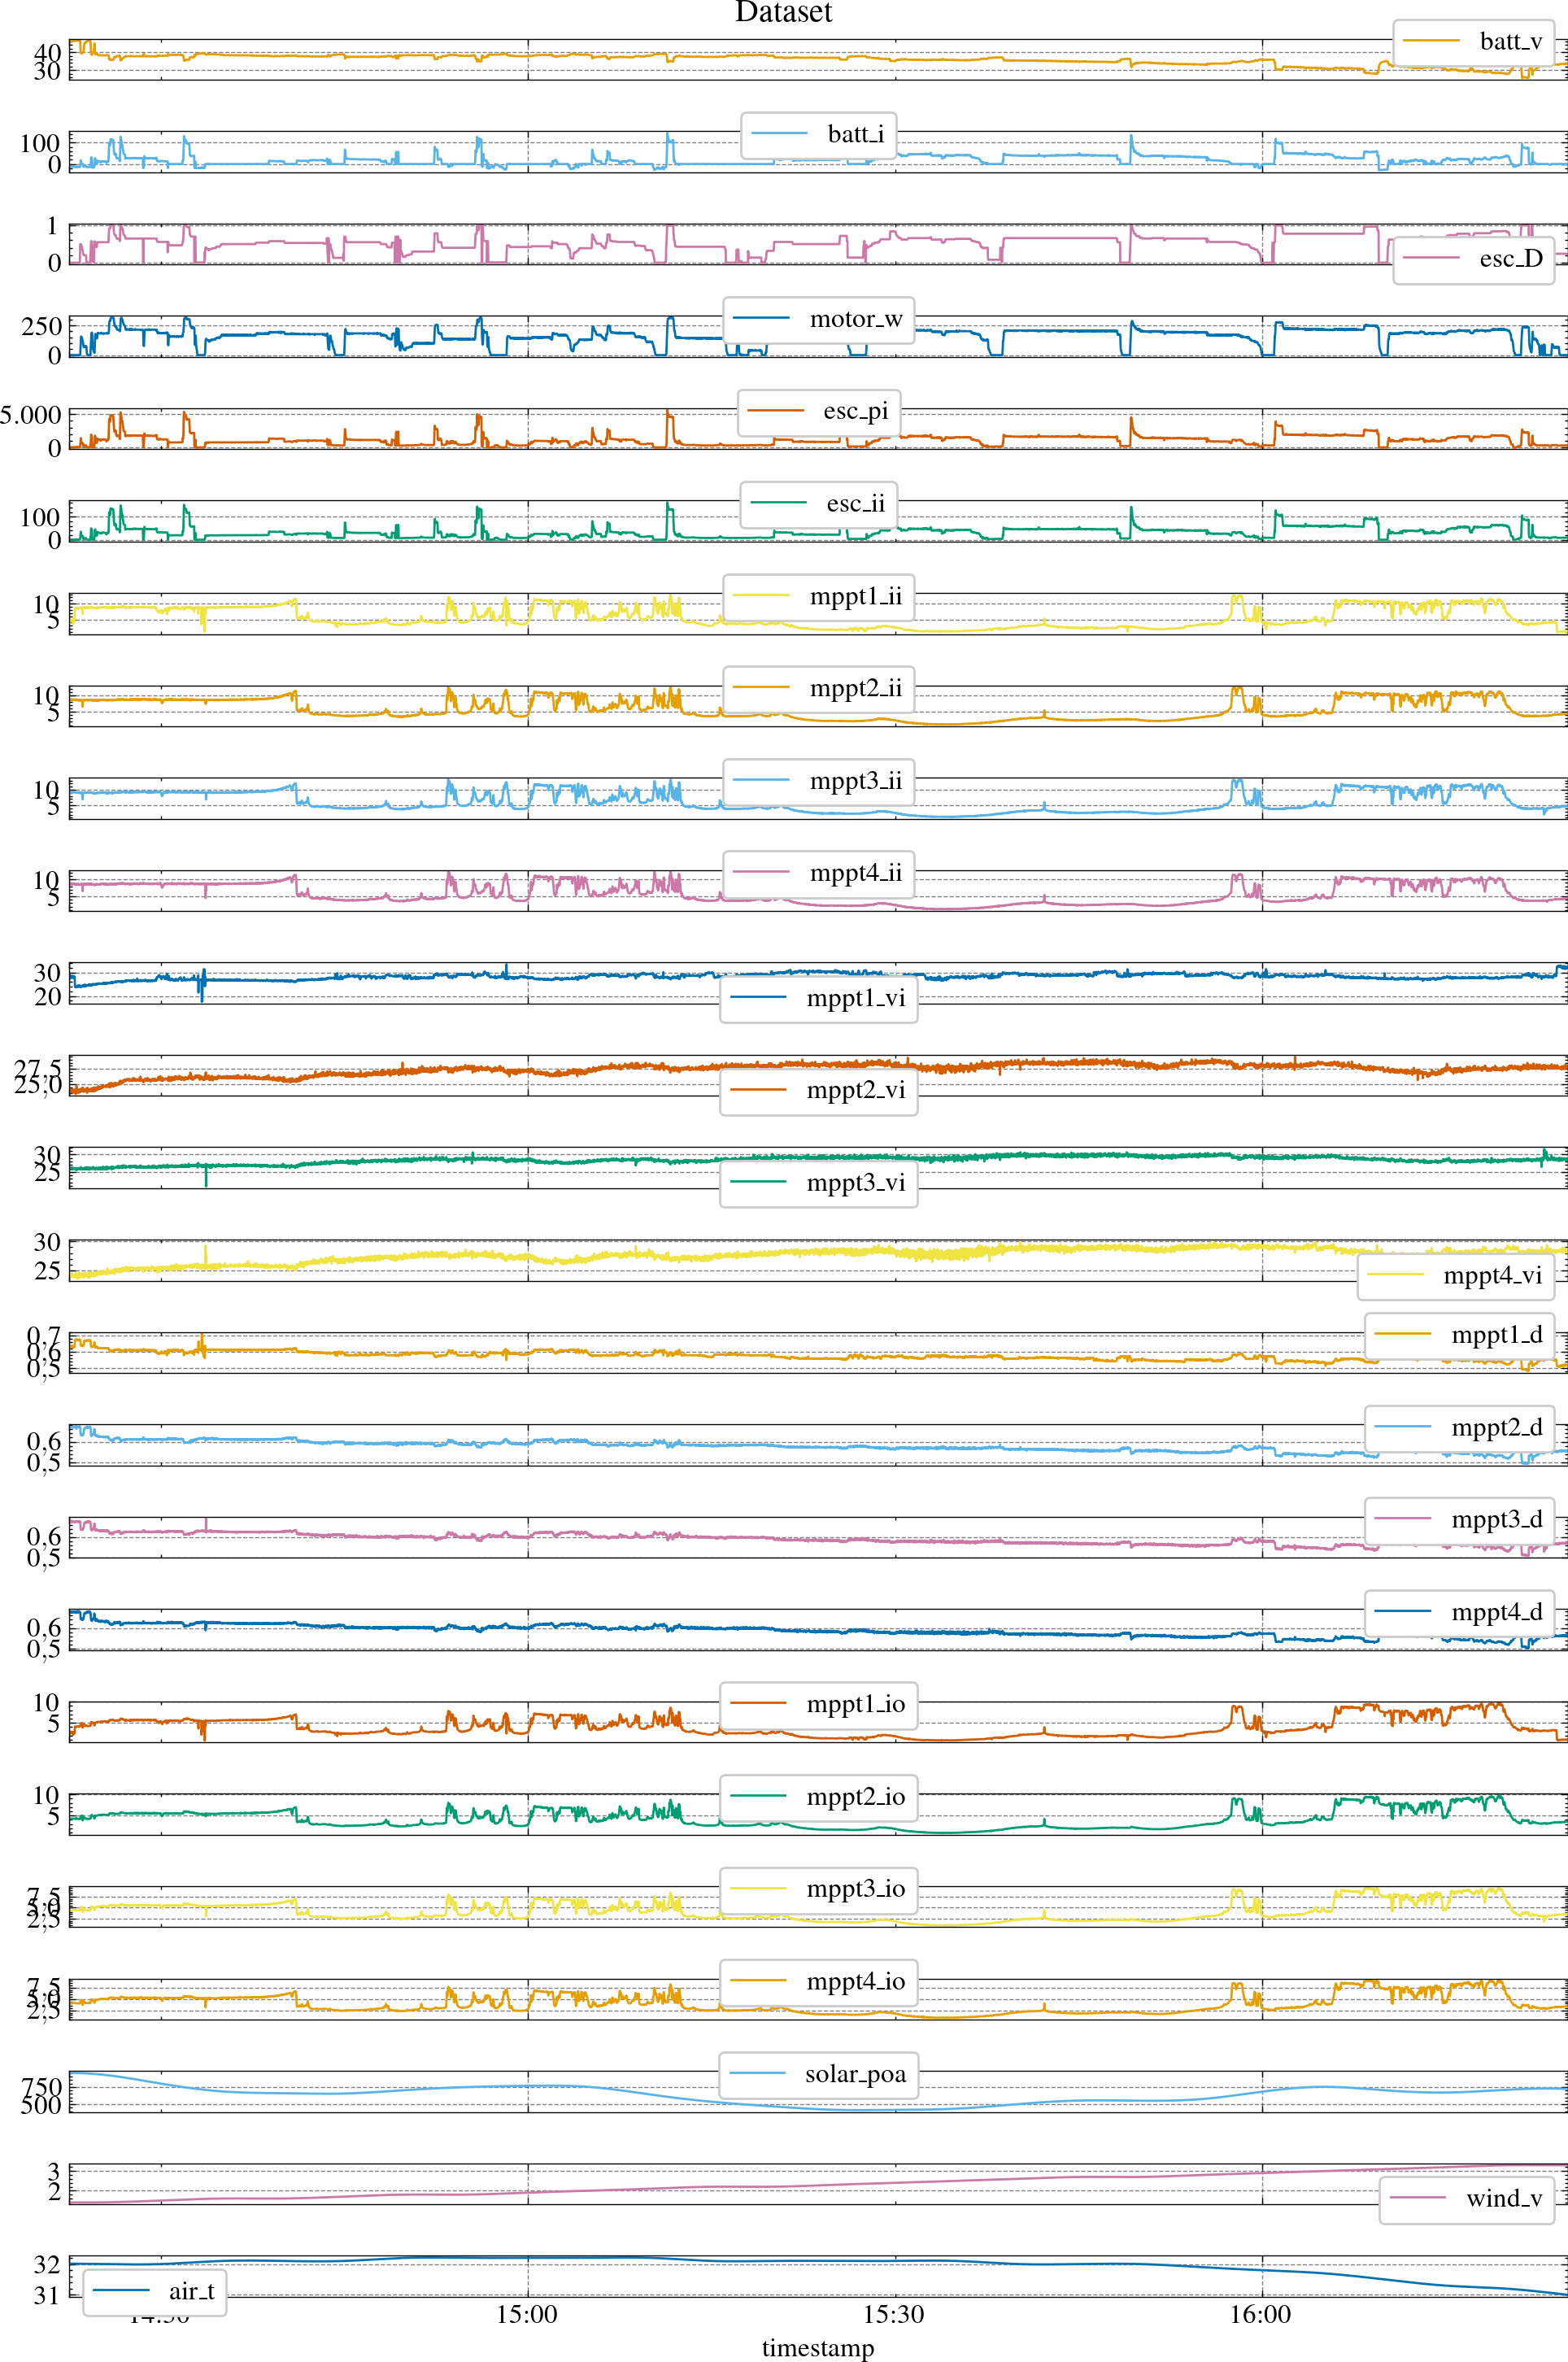

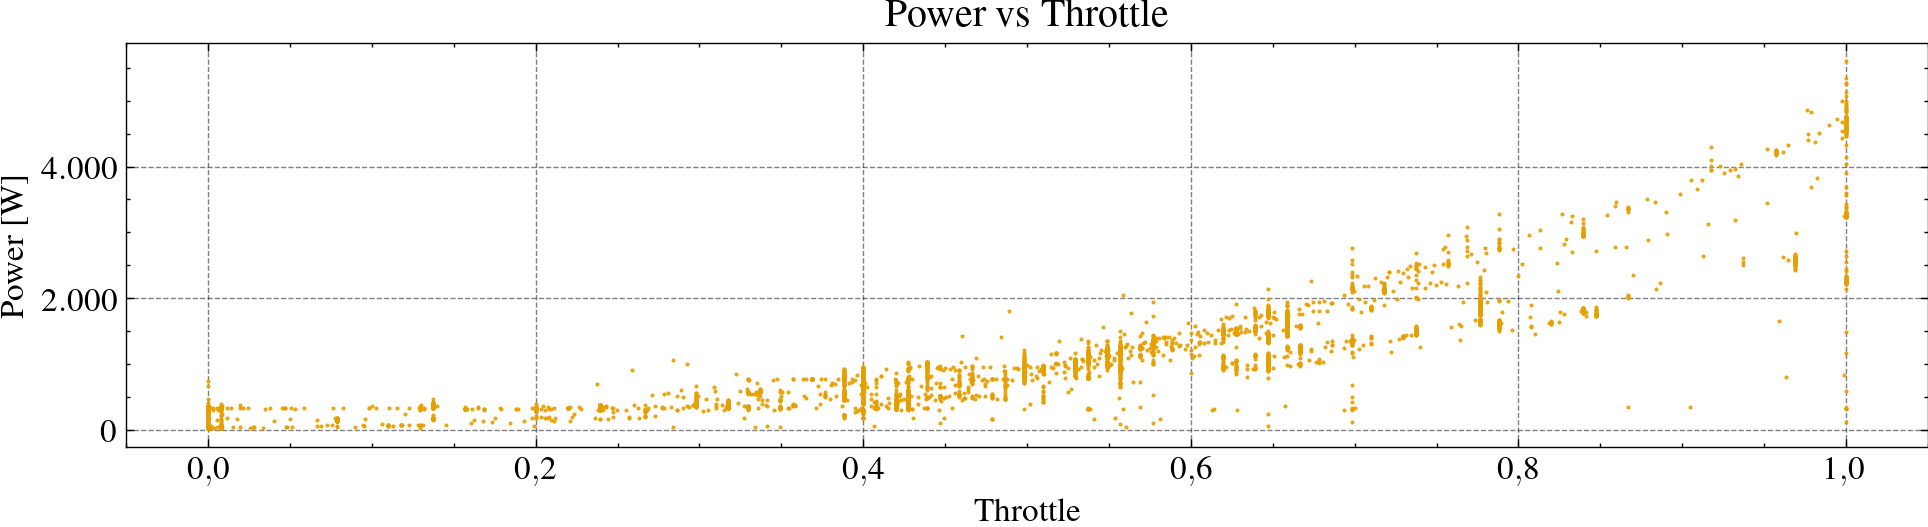

In [2]:
tzinfo = timezone("America/Sao_Paulo")

# From Revezamento
start = pd.Timestamp(
    year=2020, month=1, day=31, hour=11, minute=22, second=30, tzinfo=tzinfo
).tz_convert(None)
end = pd.Timestamp(
    year=2020, month=1, day=31, hour=13, minute=25, second=0, tzinfo=tzinfo
).tz_convert(None)

df = vaex.from_csv("../../../models/2020/boat_data_1s.csv").to_pandas_df()
# df = vaex.from_csv("../../../models/2020/boat_data_100ms.csv").to_pandas_df()
df["timestamp"] = pd.DatetimeIndex(df["timestamp"]).tz_convert(None)
df = df.set_index("timestamp")
display('original columns:', df.columns)

renamed_columns = {
    'Battery Pack Voltage': 'batt_v',
    'Battery Current': 'batt_i',
    'ESC Duty Cycle': 'esc_D',
    'Motor Angular Speed': 'motor_w',
    'ESC Input Power': 'esc_p_in',
    'ESC Input Current': 'esc_i_in',
    **{f'MPPT {i} Input Current': f'mppt{i}_i_in' for i in range(1,5)},
    **{f'MPPT {i} Input Voltage': f'mppt{i}_v_in' for i in range(1,5)},
    **{f'MPPT {i} Duty Cycle': f'mppt{i}_d' for i in range(1,5)},
    **{f'MPPT {i} Output Current': f'mppt{i}_i_out' for i in range(1,5)},
    'Solar POA': 'solar_poa',
    'Wind Speed': 'wind_v',
    'Air Temperature': 'air_t',
}
display('renamed columns:', renamed_columns)

df = df.loc[
    (df.index >= start) & (df.index <= end),
    renamed_columns.keys(),
].rename(columns=renamed_columns)

display('selected columns:', df.columns)

df = df.dropna()
df = df.resample('1s').mean().interpolate(method="time", limit_area='inside')
dfa = df.copy(deep=True)

df.plot(subplots=True, figsize=(10, 15))
plt.suptitle('Dataset')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.title('Power vs Throttle')
plt.xlabel('Throttle')
plt.ylabel('Power [W]')
plt.scatter(df['esc_D'], df['esc_p_in'], s=0.2)
plt.tight_layout()
plt.show()


In [21]:
import control as ct
from math import pi
from dataclasses import dataclass, asdict
from pprint import pformat, pprint
from copy import deepcopy

@dataclass
class PropulsionParams:
    motor_K_Q: float
    motor_R_A: float
    motor_L_A: float
    motor_I_r: float
    motor_B: float
    motor_I_r_load: float
    prop_K_Q: float
    prop_D: float
    rho_water: float
    trans_eta: float
    trans_K: float
    esc_eta: float

    def copy(self):
        return deepcopy(self)

    def asdict(self):
        return asdict(self)

    def __repr__(self):
        return pformat(self.asdict())


class Propulsion:
    @classmethod
    def _update(cls, t, x, u, params: PropulsionParams):
        # States
        motor_i = x[0]
        motor_w = x[1]

        # Inputs
        esc_D = u[0]
        batt_v = u[1]

        # Compute ESC-Motor coupling
        motor_v = batt_v*esc_D

        # Compute Motor-Transmission-Propeller coupling
        # motor_Q = 2*pi*motor_w**2*params.prop_D**5*params.prop_K_Q*params.rho_water*params.trans_K**3/params.trans_eta
        motor_Q = motor_w**2*params.prop_D**5*params.prop_K_Q*params.rho_water*params.trans_K**3/params.trans_eta

        # Compute Motor
        d_motor_i = (-params.motor_K_Q*motor_w - params.motor_R_A*motor_i + motor_v)/params.motor_L_A
        d_motor_w = (-params.motor_B*motor_w + params.motor_K_Q*motor_i - motor_Q)/(params.motor_I_r + params.motor_I_r_load)

        return np.array([d_motor_i, d_motor_w])

    @classmethod
    def _outputs(cls, t, x, u, params: PropulsionParams):
        # States
        motor_i = x[0]
        motor_w = x[1]

        # Inputs
        esc_D = u[0]

        # Compute Motor-ESC coupling
        esc_i_in = esc_D*motor_i/params.esc_eta

        return np.array([esc_i_in, motor_w])

    @classmethod
    def build(cls, params: PropulsionParams):
        return ct.NonlinearIOSystem(
            cls._update,
            cls._outputs,
            name='propulsion',
            states=('motor_i', 'motor_w'),
            inputs=('esc_D', 'batt_V'),
            outputs=('esc_i_in', 'motor_w'),
            params=params,
        )


Parameters([('motor_R_A', <Parameter 'motor_R_A', value=0.03336067 (fixed), bounds=[0.0033360670000000003:0.33360670000000003]>), ('motor_L_A', <Parameter 'motor_L_A', value=0.001, bounds=[0.0001:0.01]>), ('motor_B', <Parameter 'motor_B', value=0.00043846, bounds=[4.3846e-05:0.0043846]>), ('motor_I_r', <Parameter 'motor_I_r', value=0.039200000000000006, bounds=[0.003920000000000001:0.39200000000000007]>), ('motor_I_r_load', <Parameter 'motor_I_r_load', value=0.007807645674999999, bounds=[0.0007807645674999999:0.07807645675]>), ('motor_K_Q', <Parameter 'motor_K_Q', value=0.10225268 (fixed), bounds=[0.010225268000000001:1.0225268]>), ('prop_K_Q', <Parameter 'prop_K_Q', value=0.0022906304352845845, bounds=[0.00022906304352845845:0.022906304352845845]>), ('prop_D', <Parameter 'prop_D', value=0.21589999999999998 (fixed), bounds=[0.021589999999999998:2.159]>), ('trans_eta', <Parameter 'trans_eta', value=0.95 (fixed), bounds=[0.3:1]>), ('esc_eta', <Parameter 'esc_eta', value=0.8 (fixed), bounds=[0.3:1]>), ('trans_k', <Parameter 'trans_k', value=0.5909090909090909 (fixed), bounds=[0.0590909090909091:5.909090909090909]>), ('rho_water', <Parameter 'rho_water', value=1025 (fixed), bounds=[1000:1040]>)])

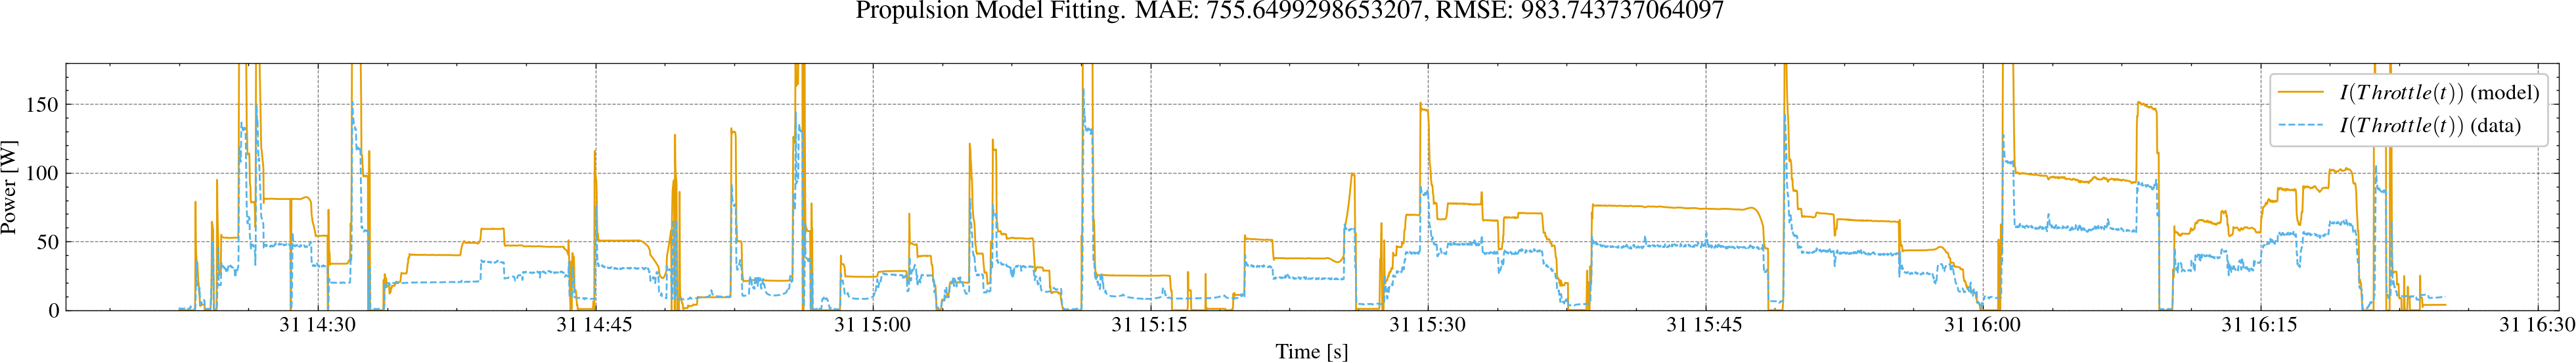

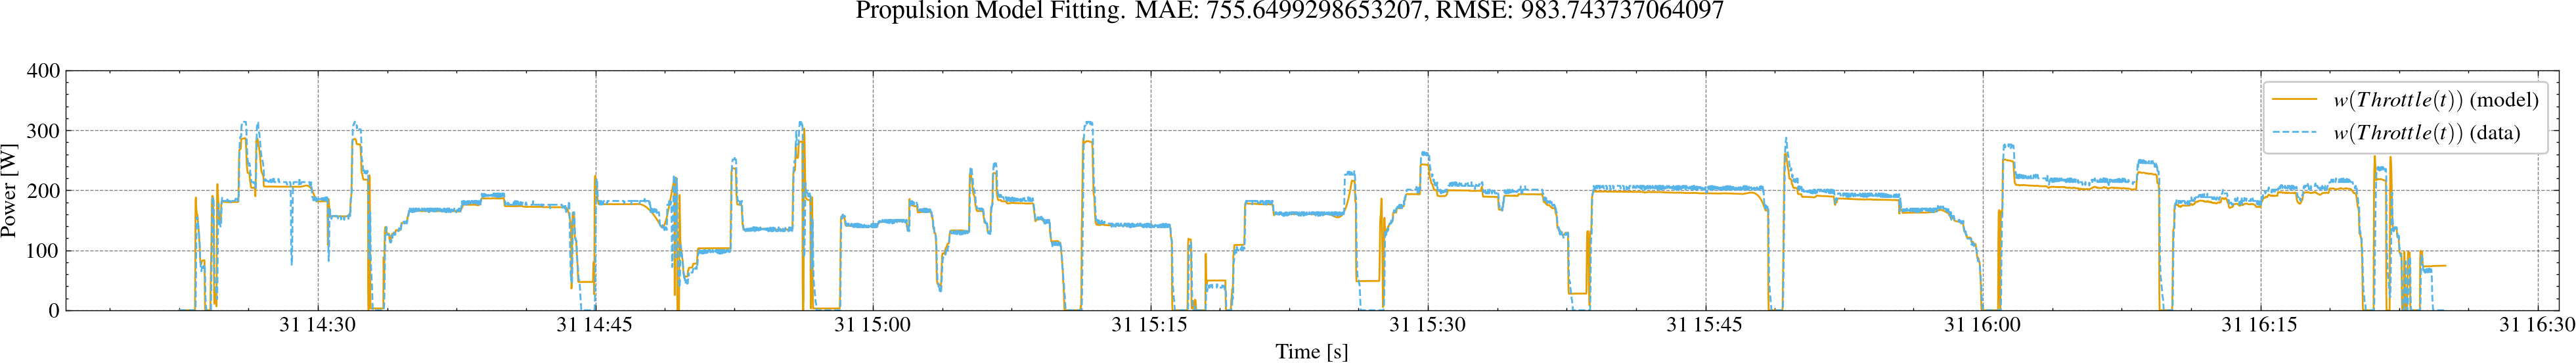

In [25]:
import lmfit

def func(T, U, X0, **params):
    return ct.input_output_response(
        Propulsion.build(PropulsionParams(**params)),
        T=T,
        U=U,
        X0=X0,
        solve_ivp_kwargs=dict(
            # https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html
            method='Radau',
        ),
    ).to_pandas()[['esc_i_in', 'motor_w']].to_numpy()

df = dfa.copy(deep=True)#.resample('30min').mean()

# Initial guesses
motor_R_A = 0.03336067  # From the motor performance curves
motor_K_Q = 0.10225268  # From the motor performance curves
motor_B = 4.3846e-04 # From the motor performance curves
motor_L_A = 1e-3 # Unknown
motor_rotor_radius = (14 / 2) / 100  # meters
motor_rotor_mass = 8  # kg
motor_I_r = motor_rotor_mass * motor_rotor_radius**2

# Considering steady-state and zero load torque and solving for motor_K_Q:
#   dwdt = (-motor_B*motor_w + motor_K_Q*motor_i - motor_Q) / (motor_I_r + motor_I_r_load)
#   didt = (-motor_K_Q*motor_w - motor_R*motor_i + motor_v) / motor_L
# The steady-state is:
#   0 = (-motor_B*motor_w + motor_K_Q*motor_i - motor_Q) / (motor_I_r + motor_I_r_load)
#   0 = (-motor_K_Q*motor_w - motor_R*motor_i + motor_v) / motor_L
# Which simplfying is:
#   0 = -motor_B*motor_w + motor_K_Q*motor_i - motor_Q
#   0 = -motor_K_Q*motor_w - motor_R*motor_i + motor_v
# Then we can solve for motor_Q:
#   motor_Q = motor_K_Q*motor_i -motor_B*motor_w
#   motor_i = (motor_v - motor_K_Q*motor_w) / motor_R
motor_v_mean = (df['batt_v'] * df['esc_D']).mean()
motor_w_mean = df['motor_w'].mean()
motor_i_mean = (motor_v_mean -motor_K_Q*motor_w_mean) / motor_R_A
motor_Q = motor_K_Q*motor_i_mean -motor_B*motor_w_mean

esc_eta = 0.8  # From measured test data
prop_D = 8.5 * 0.0254  # From the nominal propeller dimensions, it's about 70% of the measured
trans_K = 13 / 22  # From gear teeth count
trans_eta = 0.95  # Rough estimation
rho_water = 1025

# From the Propeller equation:
#   motor_Q = prop_D**5 * rho_water * prop_K_Q * motor_w**2 * trans_K**3 / trans_eta
# so isolating prop_K_Q:
#   prop_K_Q = (motor_Q * trans_eta) / (prop_D**5 * rho_water * motor_w**2 * trans_K**3)
prop_K_Q = (motor_Q * trans_eta) / (prop_D**5 * rho_water * motor_w_mean**2 * trans_K**3)

# Missing initial Guess
prop_mass = 0.67  # kg
motor_I_r_load = prop_mass * (prop_D / 2)**2

kmin = 1/10
kmax = 10

# Initialize the optimization parameters
params = lmfit.Parameters()
params.add_many(
    # Important reading about stiff problems: https://github.com/scipy/scipy/issues/11698
    # NAME, VALUE, VARY, MIN,  MAX,  EXPR, BRUTE_STEP
    ("motor_R_A", motor_R_A, False, motor_R_A*kmin, motor_R_A*kmax, None, None),  # Motor Armature Resistance [Ω]
    ("motor_L_A", motor_L_A, True, motor_L_A*kmin, motor_L_A*kmax, None, None),  # Motor Armature Inductance [Henrys]
    ("motor_B", motor_B, True, motor_B*kmin, motor_B*kmax, None, None),  # Motor Mechanical Frictional coeffiecient [Nm/(rad/s)]
    ("motor_I_r", motor_I_r, True, motor_I_r*kmin, motor_I_r*kmax, None, None),  # Motor Rotor Inertial moment [Kgm²]
    ("motor_I_r_load", motor_I_r_load, True, motor_I_r_load*kmin, motor_I_r_load*kmax, None, None),  # Motor Load Inertial moment [Kgm²]
    ("motor_K_Q", motor_K_Q, False, motor_K_Q*kmin, motor_K_Q*kmax, None, None),  # Volt-revolution ratio [V/(rad/s)]
    ("prop_K_Q", prop_K_Q, True, prop_K_Q*kmin, prop_K_Q*kmax, None, None),  # Propeller torque coefficient
    ("prop_D", prop_D, False, prop_D*kmin, prop_D*kmax, None, None),  # Nominal Propeller diameter (70% of the measured diameter) [m]
    ('trans_eta', trans_eta, False, 0.3, 1, None, None),  # Transmission Efficiency
    ('esc_eta', esc_eta, False, 0.3, 1, None, None),  # ESC efficiency
    ("trans_K", trans_K, False, trans_K*kmin, trans_K*kmax, None, None), # Transmission's gear ratio as `output speed / input speed`
    ('rho_water', rho_water, False, 1000, 1040, None, None),   # Water density [kg/m^3]
)
display(params)

model = lmfit.Model(func=func, independent_vars=['T', 'U', 'X0'])

# Time array
T = (df.index[1] - df.index[0]).to_numpy().astype(np.float64) * 1e-9   # simulation time in seconds
lenT = len(df.index)
T = np.linspace(0, lenT * T, lenT, endpoint=False)  # Recreate the time array because of numerical issues from the index datetime to float transformation

# Inputs and Optimization data
U = df[['esc_D', 'batt_v']].to_numpy().T
data = df[['esc_i_in', 'motor_w']].copy(deep=True).to_numpy()

if True:
    propulsion = Propulsion.build(PropulsionParams(**params.valuesdict()))
    X0 = np.zeros(propulsion.nstates)

    # Test initial parameters
    df_init = ct.input_output_response(
        propulsion,
        T=T,
        U=U,
        X0=X0,
        solve_ivp_kwargs={'method': 'Radau'},
    ).to_pandas()

    df['esc_p_in'] = df['esc_i_in'] * df['batt_v']
    df_init['esc_p_in'] = df_init['esc_i_in'].to_numpy() * df['batt_v'].to_numpy()

    rmse = (((df['esc_p_in'].to_numpy() - df_init['esc_p_in'].to_numpy())**2).sum() / len(df))**(1/2)
    mae = abs(df['esc_p_in'].to_numpy() - df_init['esc_p_in'].to_numpy()).sum() / len(df)

    plt.figure(figsize=(20, 3))
    plt.plot(df.index, df_init['esc_i_in'], label='$I(Throttle(t))$ (model)')
    plt.plot(df.index, df['esc_i_in'], label='$I(Throttle(t))$ (data)')
    plt.xlabel('Time [s]')
    plt.ylabel('Power [W]')
    plt.legend(loc=1)
    plt.suptitle(f'Propulsion Model Fitting. MAE: {mae}, RMSE: {rmse}')
    plt.ylim([0,180])
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(20, 3))
    plt.plot(df.index, df_init['motor_w'], label='$w(Throttle(t))$ (model)')
    plt.plot(df.index, df['motor_w'], label='$w(Throttle(t))$ (data)')
    plt.xlabel('Time [s]')
    plt.ylabel('Power [W]')
    plt.legend(loc=1)
    plt.suptitle(f'Propulsion Model Fitting. MAE: {mae}, RMSE: {rmse}')
    plt.ylim([0,400])
    plt.tight_layout()
    plt.show()

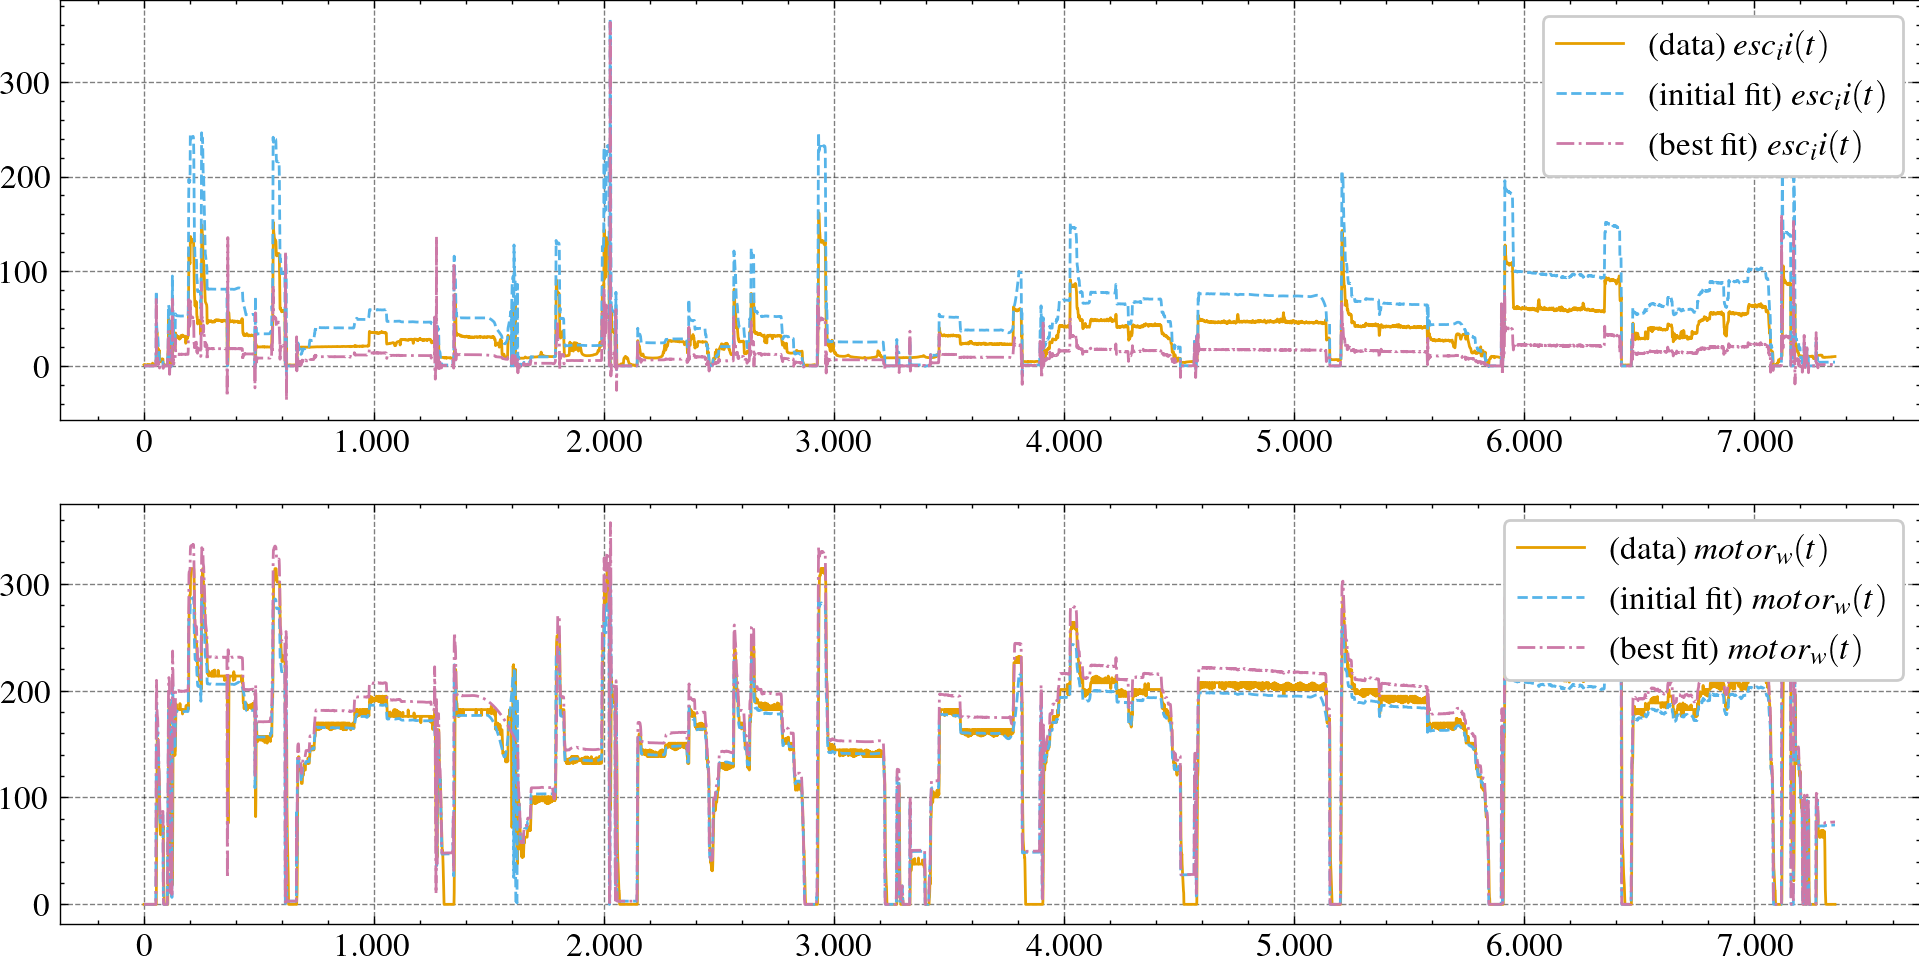

In [26]:
# Time array
T = (df.index[1] - df.index[0]).to_numpy().astype(np.float64) * 1e-9   # simulation time in seconds
lenT = len(df.index)
T = np.linspace(0, lenT * T, lenT, endpoint=False)  # Recreate the time array because of numerical issues from the index datetime to float transformation

# Inputs and Optimization data
U = df[['esc_D', 'batt_v']].to_numpy().T
data = df[['esc_i_in', 'motor_w']].copy(deep=True).to_numpy()

# Optimize
result = model.fit(
    data=data,
    params=params,
    T=T,
    U=U,
    X0=X0,
    method='shgo', # 47s  # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.shgo.html
    fit_kws=dict(
        workers=-1,
    )
)

fig, ax = plt.subplots(result.data.shape[1], figsize=(12, 3*result.data.shape[1]))
for i, (initial, best, data) in enumerate(
    zip(result.init_fit.T, result.best_fit.T, result.data.T)
):
    label = Propulsion.build({}).output_labels[i]

    ax[i].plot(data, label=f'(data) ${label}(t)$')
    ax[i].plot(initial, label=f'(initial fit) ${label}(t)$')
    ax[i].plot(best, label=f'(best fit) ${label}(t)$')
    ax[i].legend(loc=1)

plt.show()

result

In [27]:
params_best = result.params.valuesdict()
params_best

{'motor_R_A': 0.03336067,
 'motor_L_A': 0.0001,
 'motor_B': 0.0043846,
 'motor_I_r': 0.003920000000000001,
 'motor_I_r_load': 0.07807645675,
 'motor_K_Q': 0.10225268,
 'prop_K_Q': 0.00022906304352845845,
 'prop_D': 0.21589999999999998,
 'trans_eta': 0.95,
 'esc_eta': 0.8,
 'trans_k': 0.5909090909090909,
 'rho_water': 1025}

/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_no

differential_evolution step 1: f(x)= 3976764.226203331


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_no

differential_evolution step 2: f(x)= 3976764.226203331


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 3: f(x)= 3976764.226203331


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_no

differential_evolution step 4: f(x)= 3976764.226203331


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_no

differential_evolution step 5: f(x)= 3976764.226203331
differential_evolution step 6: f(x)= 3976764.226203331


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 7: f(x)= 3948048.923206647


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_no

differential_evolution step 8: f(x)= 3889443.9266956537


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 9: f(x)= 3889443.9266956537


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_no

differential_evolution step 10: f(x)= 3889443.9266956537


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_no

differential_evolution step 11: f(x)= 3745584.320696417


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_no

differential_evolution step 12: f(x)= 3745584.320696417


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_no

differential_evolution step 13: f(x)= 3745584.320696417


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_no

differential_evolution step 14: f(x)= 3745584.320696417


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_no

differential_evolution step 15: f(x)= 3745584.320696417


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_no

differential_evolution step 16: f(x)= 3745584.320696417


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_no

differential_evolution step 17: f(x)= 3745584.320696417


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_no

differential_evolution step 18: f(x)= 3745584.320696417


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 19: f(x)= 3745584.320696417


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_no

differential_evolution step 20: f(x)= 3745584.320696417


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_no

differential_evolution step 21: f(x)= 3745584.320696417


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_no

differential_evolution step 22: f(x)= 3745584.320696417


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_no

differential_evolution step 23: f(x)= 3745584.320696417


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 24: f(x)= 3745584.320696417


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_no

differential_evolution step 25: f(x)= 3745584.320696417
differential_evolution step 26: f(x)= 3745584.320696417


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_no

differential_evolution step 27: f(x)= 3702588.999305021


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 28: f(x)= 3702588.999305021


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 29: f(x)= 3702588.999305021
differential_evolution step 30: f(x)= 3702588.999305021
differential_evolution step 31: f(x)= 3702588.999305021


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 32: f(x)= 3702588.999305021
differential_evolution step 33: f(x)= 3702588.999305021


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 34: f(x)= 3702588.999305021
differential_evolution step 35: f(x)= 3702588.999305021
differential_evolution step 36: f(x)= 3702588.999305021
differential_evolution step 37: f(x)= 3702588.999305021


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 38: f(x)= 3702588.999305021


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 39: f(x)= 3702588.999305021


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 40: f(x)= 3702588.999305021


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 41: f(x)= 3702588.999305021


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 42: f(x)= 3702588.999305021
differential_evolution step 43: f(x)= 3702588.999305021
differential_evolution step 44: f(x)= 3702588.999305021


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 45: f(x)= 3702588.999305021


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 46: f(x)= 3702588.999305021
differential_evolution step 47: f(x)= 3702588.999305021
differential_evolution step 48: f(x)= 3702588.999305021
differential_evolution step 49: f(x)= 3702588.999305021


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 50: f(x)= 3702588.999305021


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 51: f(x)= 3702588.999305021


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 52: f(x)= 3702588.999305021


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 53: f(x)= 3702588.999305021


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 54: f(x)= 3702588.999305021


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 55: f(x)= 3702588.999305021
differential_evolution step 56: f(x)= 3702588.999305021
differential_evolution step 57: f(x)= 3702588.999305021
differential_evolution step 58: f(x)= 3702588.999305021
differential_evolution step 59: f(x)= 3702588.999305021


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 60: f(x)= 3702588.999305021


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 61: f(x)= 3702588.999305021
differential_evolution step 62: f(x)= 3702588.999305021
differential_evolution step 63: f(x)= 3702588.999305021
differential_evolution step 64: f(x)= 3702588.999305021
differential_evolution step 65: f(x)= 3702588.999305021


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 66: f(x)= 3702588.999305021
differential_evolution step 67: f(x)= 3702588.999305021


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 68: f(x)= 3702588.999305021


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 69: f(x)= 3702588.999305021
differential_evolution step 70: f(x)= 3702588.999305021


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 71: f(x)= 3702588.999305021


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 72: f(x)= 3702588.999305021
differential_evolution step 73: f(x)= 3702588.999305021
differential_evolution step 74: f(x)= 3702588.999305021
differential_evolution step 75: f(x)= 3702588.999305021


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 76: f(x)= 3702588.999305021
differential_evolution step 77: f(x)= 3702588.999305021
differential_evolution step 78: f(x)= 3682630.131311035
differential_evolution step 79: f(x)= 3682630.131311035
differential_evolution step 80: f(x)= 3682630.131311035


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 81: f(x)= 3682630.131311035


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 82: f(x)= 3682630.131311035
differential_evolution step 83: f(x)= 3682630.131311035
differential_evolution step 84: f(x)= 3682630.131311035


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 85: f(x)= 3682630.131311035


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 86: f(x)= 3682630.131311035
differential_evolution step 87: f(x)= 3682630.131311035


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 88: f(x)= 3682630.131311035
differential_evolution step 89: f(x)= 3682630.131311035


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 90: f(x)= 3682630.131311035
differential_evolution step 91: f(x)= 3682630.131311035


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 92: f(x)= 3682630.131311035


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 93: f(x)= 3682630.131311035


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 94: f(x)= 3682630.131311035


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 95: f(x)= 3682630.131311035


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 96: f(x)= 3682630.131311035
differential_evolution step 97: f(x)= 3682630.131311035
differential_evolution step 98: f(x)= 3682630.131311035


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 99: f(x)= 3682630.131311035
differential_evolution step 100: f(x)= 3682630.131311035


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 101: f(x)= 3682630.131311035


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25
/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 102: f(x)= 3682630.131311035


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 103: f(x)= 3682630.131311035


/home/joaoantoniocardoso/workspace_TCC/repo_2022_2/.env/lib/python3.10/site-packages/scipy/integrate/_ivp/radau.py:171: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = h_abs / h_abs_old * (error_norm_old / error_norm) ** 0.25


differential_evolution step 104: f(x)= 3682630.131311035
Polishing solution with 'L-BFGS-B'


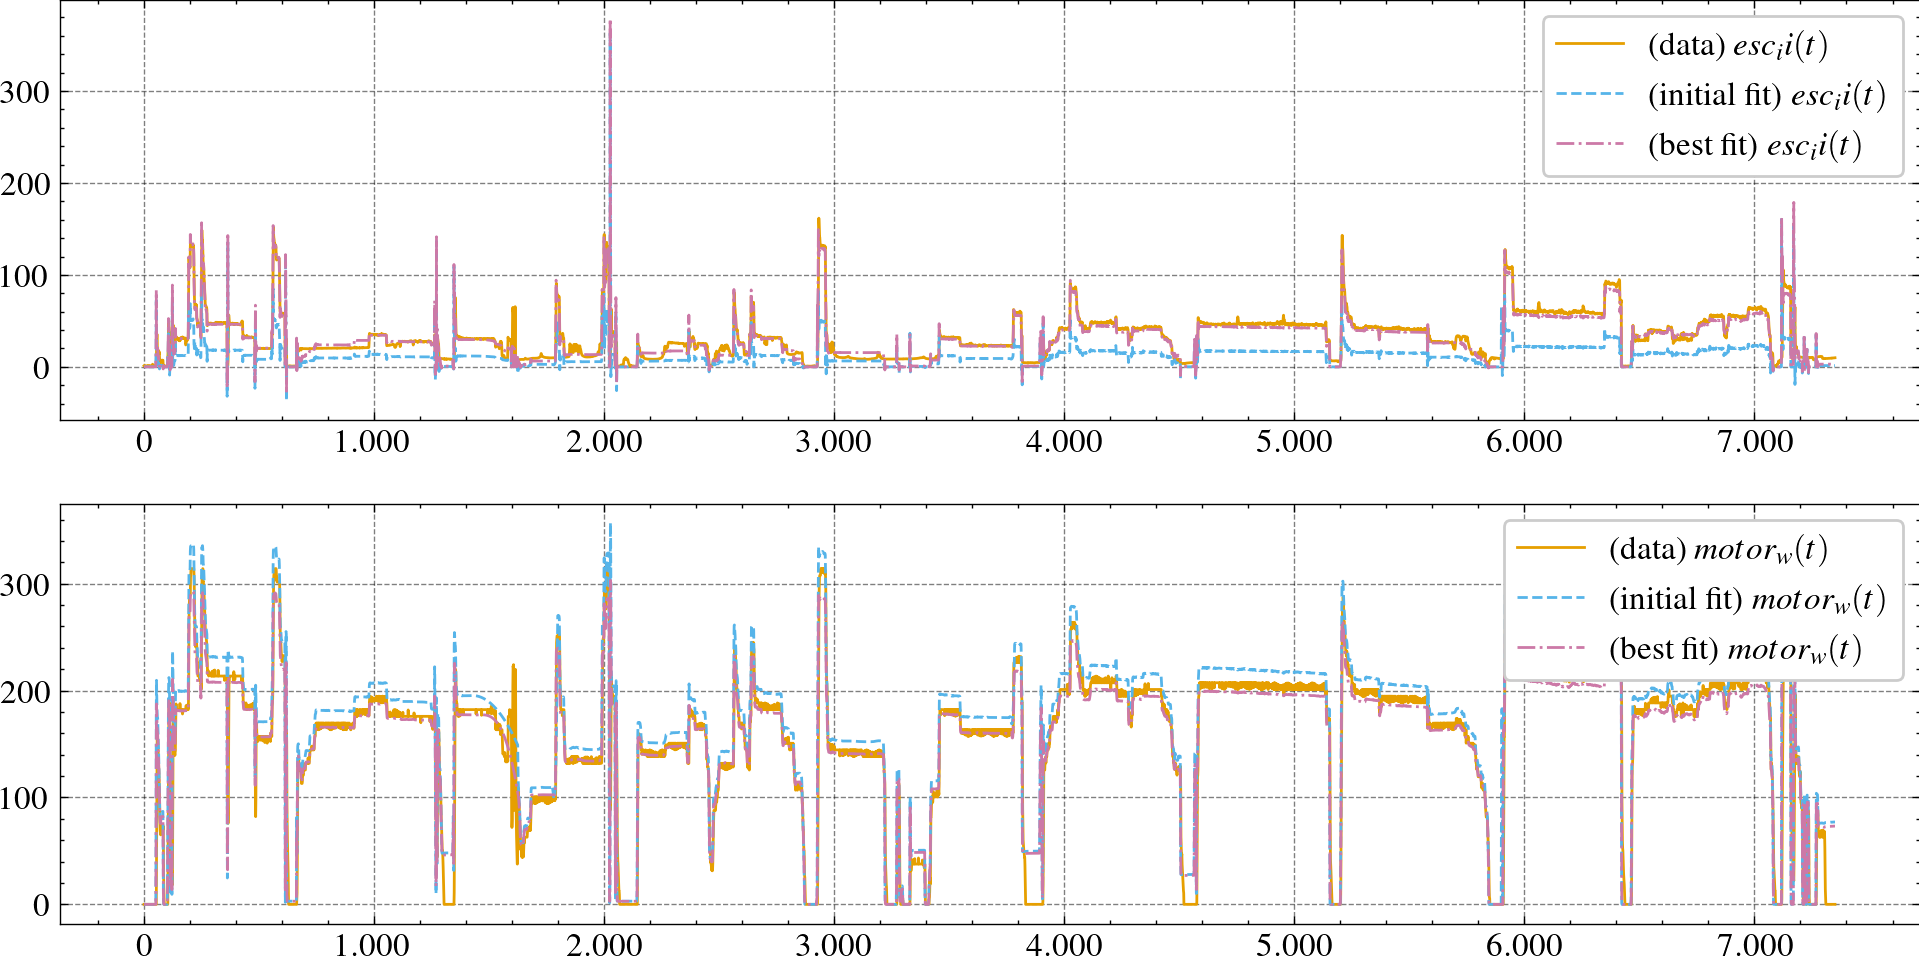

In [28]:
motor_R_A = params_best['motor_R_A']
motor_L_A = params_best['motor_L_A']
motor_B = params_best['motor_B']
motor_I_r = params_best['motor_I_r']
motor_I_r_load = params_best['motor_I_r_load']
motor_K_Q = params_best['motor_K_Q']
prop_K_Q = params_best['prop_K_Q']
prop_D = params_best['prop_D']
trans_eta = params_best['trans_eta']
esc_eta = params_best['esc_eta']
trans_K = params_best['trans_k']
rho_water = params_best['rho_water']

kmin = 1/10
kmax = 10

params = lmfit.Parameters()
params.add_many(
    # Important reading about stiff problems: https://github.com/scipy/scipy/issues/11698
    # NAME, VALUE, VARY, MIN,  MAX,  EXPR, BRUTE_STE1
    ("motor_R_A", motor_R_A, True, motor_R_A*kmin, motor_R_A*kmax, None, None),  # Motor Armature Resistance [Ω]
    ("motor_L_A", motor_L_A, True, motor_L_A*kmin, motor_L_A*kmax, None, None),  # Motor Armature Inductance [Henrys]
    ("motor_B", motor_B, True, motor_B*kmin, motor_B*kmax, None, None),  # Motor Mechanical Frictional coeffiecient [Nm/(rad/s)]
    ("motor_I_r", motor_I_r, True, motor_I_r*kmin, motor_I_r*kmax, None, None),  # Motor Rotor Inertial moment [Kgm²]
    ("motor_I_r_load", motor_I_r_load, True, motor_I_r_load*kmin, motor_I_r_load*kmax, None, None),  # Motor Load Inertial moment [Kgm²]
    ("motor_K_Q", motor_K_Q, False, motor_K_Q*kmin, motor_K_Q*kmax, None, None),  # Volt-revolution ratio [V/(rad/s)]
    ("prop_K_Q", prop_K_Q, True, prop_K_Q*kmin, prop_K_Q*kmax, None, None),  # Propeller torque coefficient
    ("prop_D", prop_D, False, prop_D*kmin, prop_D*kmax, None, None),  # Nominal Propeller diameter (70% of the measured diameter) [m]
    ('trans_eta', trans_eta, False, 0.3, 1, None, None),  # Transmission Efficiency
    ('esc_eta', esc_eta, False, 0.3, 1, None, None),  # ESC efficiency
    ("trans_K", trans_K, False, trans_K*kmin, trans_K*kmax, None, None), # Transmission's gear ratio as `output speed / input speed`
    ('rho_water', rho_water, False, 1000, 1040, None, None),   # Water density [kg/m^3]
)

# Time array
T = (df.index[1] - df.index[0]).to_numpy().astype(np.float64) * 1e-9   # simulation time in seconds
lenT = len(df.index)
T = np.linspace(0, lenT * T, lenT, endpoint=False)  # Recreate the time array because of numerical issues from the index datetime to float transformation

# Inputs and Optimization data
U = df[['esc_D', 'batt_v']].to_numpy().T
data = df[['esc_i_in', 'motor_w']].copy(deep=False).to_numpy()

# Optimize
result = model.fit(
    data=data,
    params=params,
    T=T,
    U=U,
    X0=X0,
    # method='shgo',  # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.shgo.html
    # fit_kws=dict(
    #     workers=-1,
    # )
    method="differential_evolution",  # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html
    fit_kws=dict(
        updating="deferred",
        disp=True,
        polish=True,
        workers=-1,
        # max_nfev=100_000,
        seed=1,
        # strategy="currenttobest1bin",
        strategy="randtobest1bin",
    )
)

fig, ax = plt.subplots(result.data.shape[1], figsize=(12, 3*result.data.shape[1]))
for i, (initial, best, data) in enumerate(
    zip(result.init_fit.T, result.best_fit.T, result.data.T)
):
    label = Propulsion.build({}).output_labels[i]

    ax[i].plot(data, label=f'(data) ${label}(t)$')
    ax[i].plot(initial, label=f'(initial fit) ${label}(t)$')
    ax[i].plot(best, label=f'(best fit) ${label}(t)$')
    ax[i].legend(loc=1)

plt.show()

result

In [30]:
# df_init = ct.input_output_response(
#     Propulsion.build(params.valuesdict()),
#     T=T,
#     U=U,
#     solve_ivp_kwargs={"method": "Radau"},
# ).to_pandas()

df_best = ct.input_output_response(
    Propulsion.build(PropulsionParams(**result.params.valuesdict())),
    T=T,
    U=U,
    solve_ivp_kwargs={"method": "Radau"},
).to_pandas()

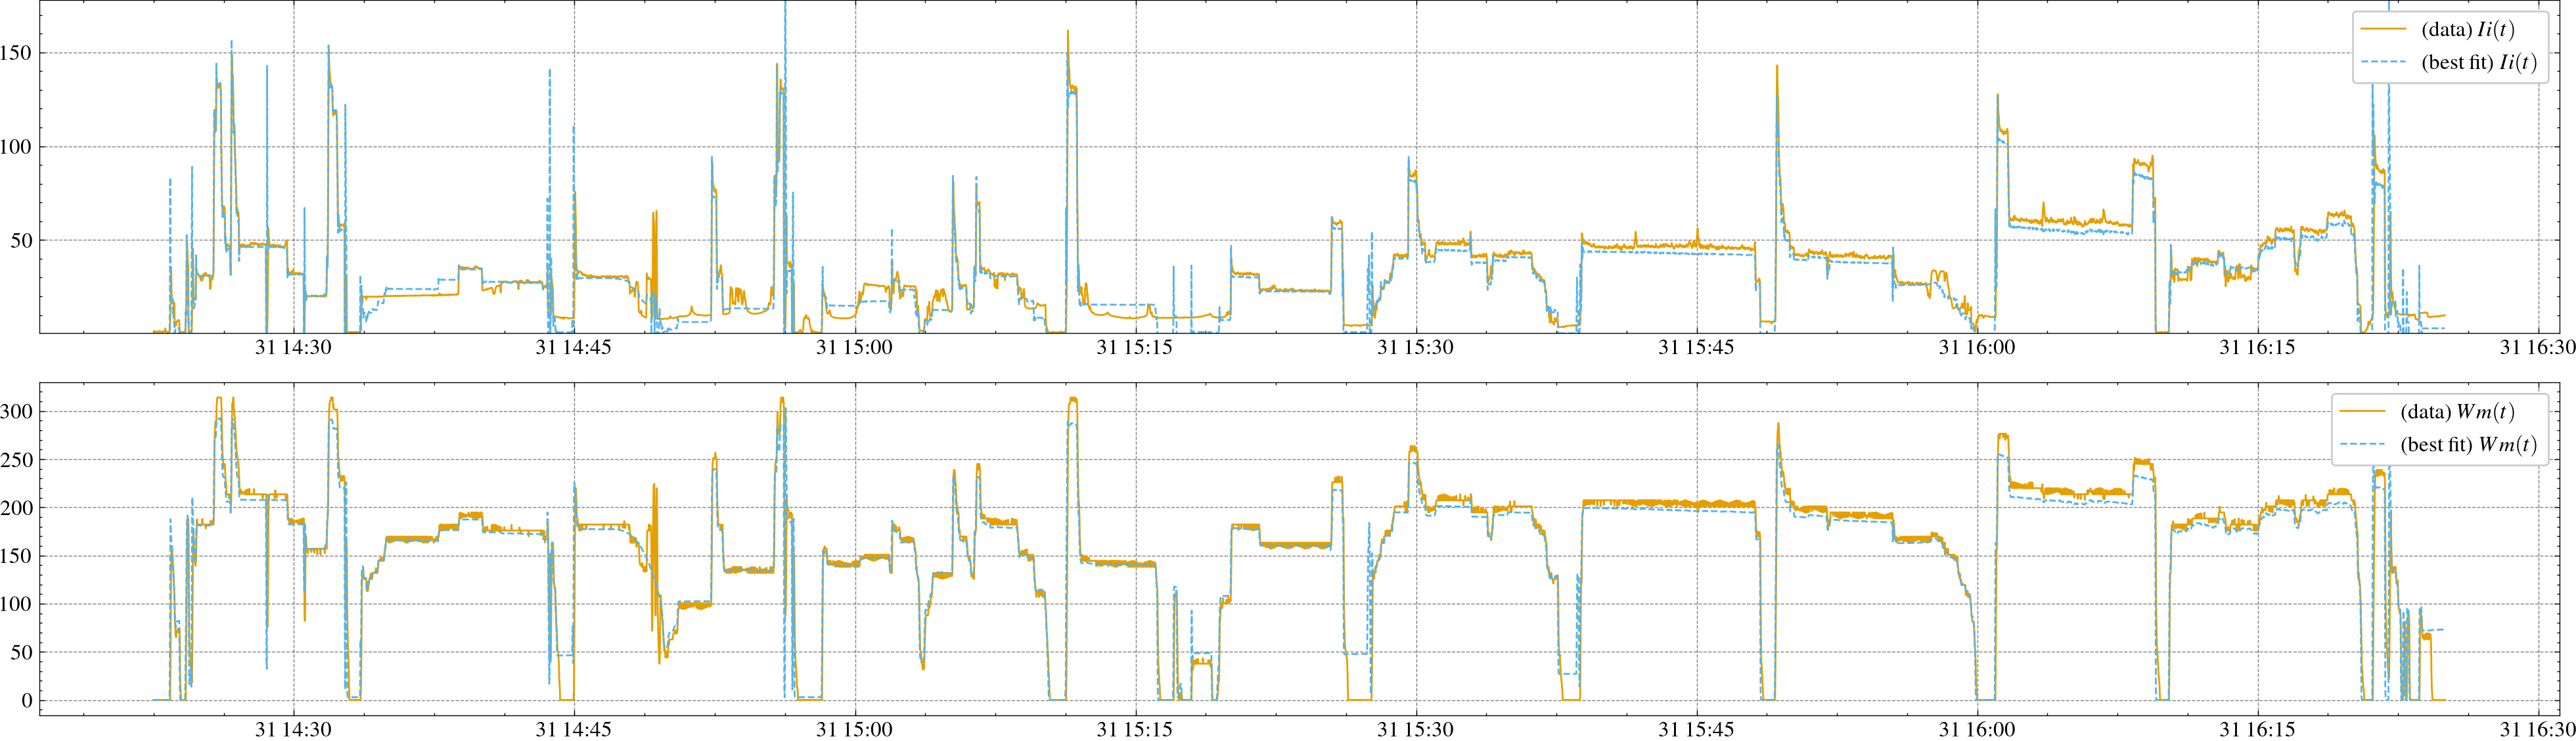

In [31]:
fig, ax = plt.subplots(2, figsize=(20, 3 * 2))

ax[0].plot(df.index, df["esc_i_in"], label="(data) $Ii(t)$")
# ax[0].plot(df.index, df_init["esc_i_in"], "--", label="(initial fit) $Ii(t)$")
ax[0].plot(df.index, df_best["esc_i_in"], "--", label="(best fit) $Ii(t)$")
ax[0].set_ylim((df["esc_i_in"].min()*1.1, df["esc_i_in"].max()*1.1))
ax[0].legend(loc=1)

ax[1].plot(df.index, df["motor_w"], label="(data) $Wm(t)$")
# ax[1].plot(df.index, df_init["motor_w"], "--", label="(initial fit) $Wm(t)$")
ax[1].plot(df.index, df_best["motor_w"], "--", label="(best fit) $Wm(t)$")
ax[1].legend(loc=1)

plt.tight_layout()
plt.show()

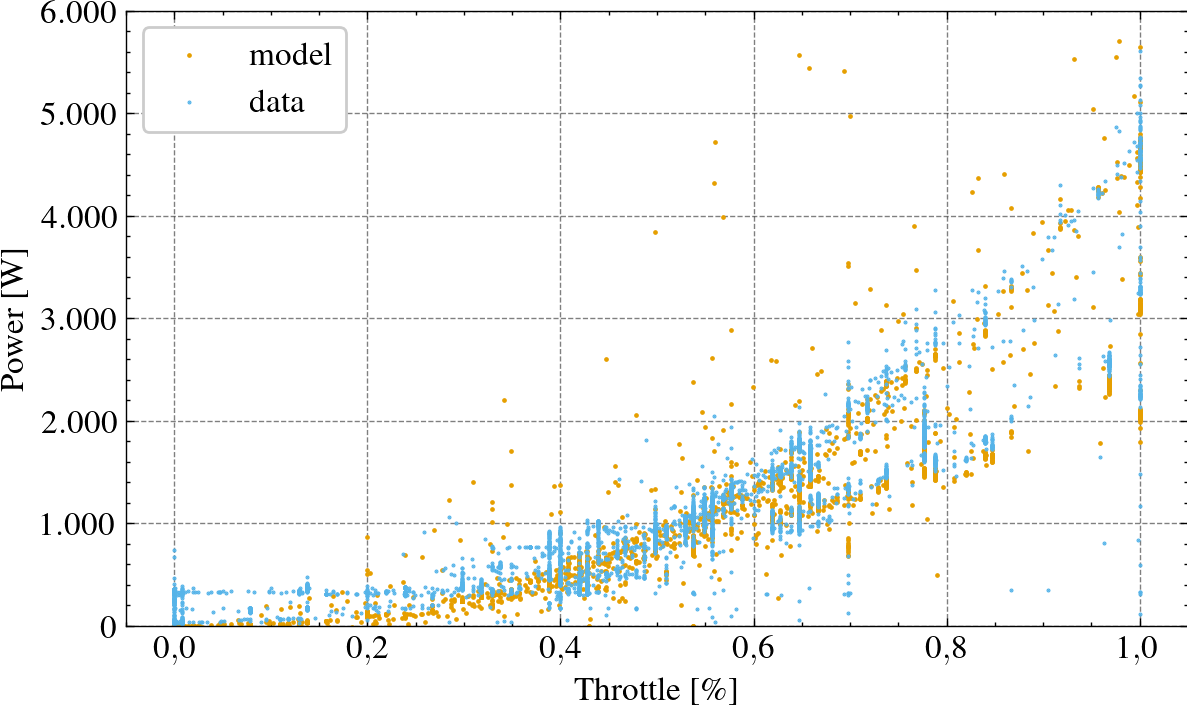

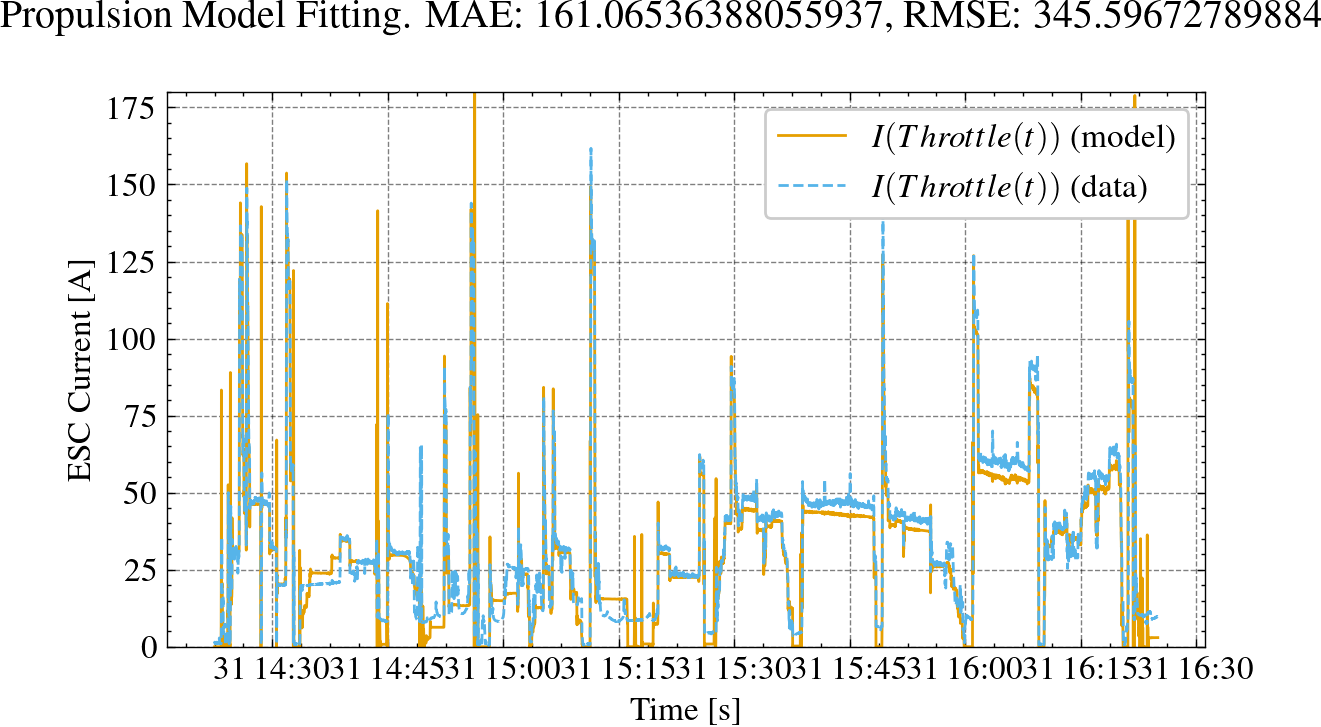

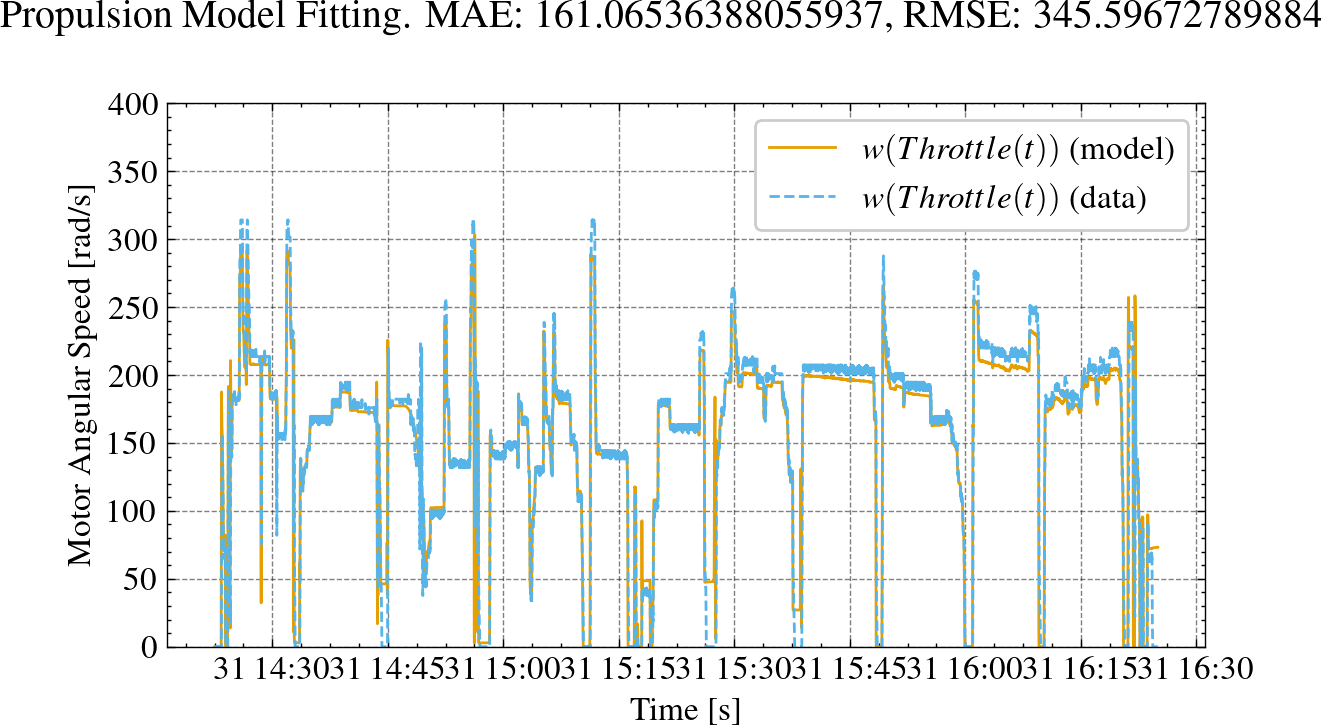

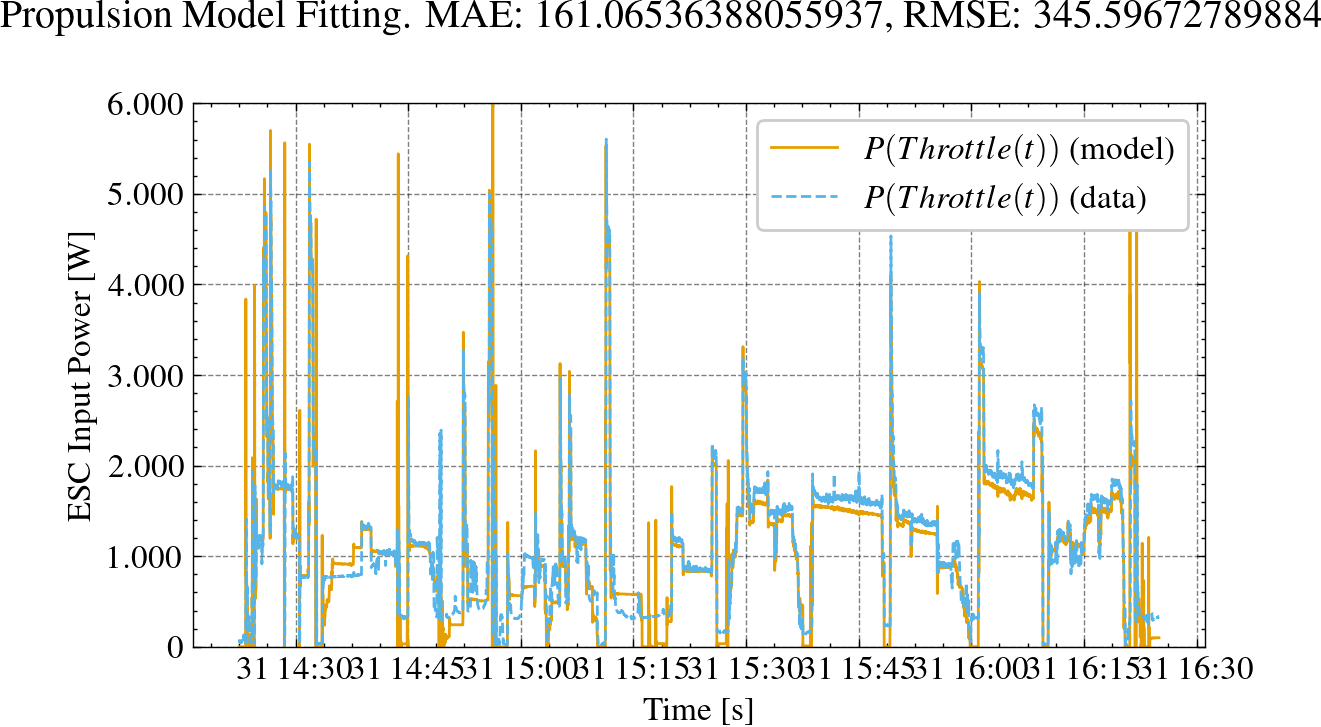

In [32]:
df['esc_p_in'] = df['esc_i_in'] * df['batt_v']
df_best['esc_p_in'] = df_best['esc_i_in'].to_numpy() * df['batt_v'].to_numpy()
df_init['esc_p_in'] = df_init['esc_i_in'].to_numpy() * df['batt_v'].to_numpy()

rmse = (((df['esc_p_in'].to_numpy() - df_best['esc_p_in'].to_numpy())**2).sum() / len(df))**(1/2)
mae = abs(df['esc_p_in'].to_numpy() - df_best['esc_p_in'].to_numpy()).sum() / len(df)

plt.figure()
# plt.scatter(df['esc_D'], df_init['esc_p_in'], label='model', s=0.5)
plt.scatter(df['esc_D'], df_best['esc_p_in'], label='model', s=0.5)
plt.scatter(df['esc_D'], df['esc_p_in'], label='data', s=0.2)
plt.xlabel('Throttle [\%]')
plt.ylabel('Power [W]')
plt.legend(loc=0)
# plt.suptitle('Power vs Throttle')
plt.ylim([0,6000])
plt.tight_layout()
plt.show()

plt.figure()
# plt.plot(df.index, df_init['esc_i_in'], label='$I(Throttle(t))$ (model)')
plt.plot(df.index, df_best['esc_i_in'], label='$I(Throttle(t))$ (model)')
plt.plot(df.index, df['esc_i_in'], label='$I(Throttle(t))$ (data)')
plt.xlabel('Time [s]')
plt.ylabel('ESC Current [A]')
plt.legend(loc=1)
plt.suptitle(f"Propulsion Model Fitting. MAE: {mae}, RMSE: {rmse}")
plt.ylim([0,180])
plt.tight_layout()
plt.show()

plt.figure()
# plt.plot(df.index, df_init['motor_w'], label='$I(Throttle(t))$ (model)')
plt.plot(df.index, df_best['motor_w'], label='$w(Throttle(t))$ (model)')
plt.plot(df.index, df['motor_w'], label='$w(Throttle(t))$ (data)')
plt.xlabel('Time [s]')
plt.ylabel('Motor Angular Speed [rad/s]')
plt.legend(loc=1)
plt.suptitle(f"Propulsion Model Fitting. MAE: {mae}, RMSE: {rmse}")
plt.ylim([0,400])
plt.tight_layout()
plt.show()

plt.figure()
# plt.plot(df.index, df_init['esc_p_in'], label='$P(Throttle(t))$ (model)')
plt.plot(df.index, df_best['esc_p_in'], label='$P(Throttle(t))$ (model)')
plt.plot(df.index, df['esc_p_in'], label='$P(Throttle(t))$ (data)')
plt.xlabel('Time [s]')
plt.ylabel('ESC Input Power [W]')
plt.legend(loc=1)
plt.suptitle(f"Propulsion Model Fitting. MAE: {mae}, RMSE: {rmse}")
plt.ylim([0,6000])
plt.tight_layout()
plt.show()

In [34]:
result.params.valuesdict()

{'motor_R_A': 0.055216545026004704,
 'motor_L_A': 0.0002526738306279513,
 'motor_B': 0.006064062696310801,
 'motor_I_r': 0.0020689388348319702,
 'motor_I_r_load': 0.09165397856170968,
 'motor_K_Q': 0.10225268,
 'prop_K_Q': 0.0010199038051000998,
 'prop_D': 0.21589999999999998,
 'trans_eta': 0.95,
 'esc_eta': 0.8,
 'trans_k': 0.5909090909090909,
 'rho_water': 1025}